##*import libraries*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
import os

##*load data*

In [ ]:
!pip install -q kaggle
from google.colab import files
import os, shutil
from sklearn.model_selection import train_test_split

files.upload()
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

!kaggle datasets download -d gti-upm/leapgestrecog
!unzip -q leapgestrecog.zip -d leap_dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
 99% 2.11G/2.13G [00:33<00:00, 209MB/s]
100% 2.13G/2.13G [00:34<00:00, 67.2MB/s]


In [ ]:
DATASET = "/content/leap_dataset/leapGestRecog"
BASE = "/content/processed"
CLASSES = sorted([d for d in os.listdir(DATASET) if os.path.isdir(os.path.join(DATASET, d))])
splits = ['train','val','test']
for split in splits:
    for cls in CLASSES:
        os.makedirs(os.path.join(BASE, split, cls), exist_ok=True)

for cls in CLASSES:
    cls_path = os.path.join(DATASET, cls)
    images = []
    for sub in os.listdir(cls_path):
        sub_path = os.path.join(cls_path, sub)
        if os.path.isdir(sub_path):
            for img in os.listdir(sub_path):
                if img.lower().endswith((".png",".jpg",".jpeg")):
                    images.append(os.path.join(sub_path,img))
    if not images: continue
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)
    for img_path in train_imgs: shutil.copy(img_path, os.path.join(BASE,'train',cls,os.path.basename(img_path)))
    for img_path in val_imgs: shutil.copy(img_path, os.path.join(BASE,'val',cls,os.path.basename(img_path)))
    for img_path in test_imgs: shutil.copy(img_path, os.path.join(BASE,'test',cls,os.path.basename(img_path)))
print("Dataset split completed!")


Dataset split completed!


In [ ]:
for split in splits:
    print(f"\n=== {split.upper()} ===")
    split_path = os.path.join(BASE, split)
    for cls in sorted(os.listdir(split_path)):
        cls_path = os.path.join(split_path, cls)
        num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))])
        print(f"Class {cls}: {num_images} images")


=== TRAIN ===
Class 00: 1400 images
Class 01: 1400 images
Class 02: 1400 images
Class 03: 1400 images
Class 04: 1400 images
Class 05: 1400 images
Class 06: 1400 images
Class 07: 1400 images
Class 08: 1400 images
Class 09: 1400 images

=== VAL ===
Class 00: 300 images
Class 01: 300 images
Class 02: 300 images
Class 03: 300 images
Class 04: 300 images
Class 05: 300 images
Class 06: 300 images
Class 07: 300 images
Class 08: 300 images
Class 09: 300 images

=== TEST ===
Class 00: 300 images
Class 01: 300 images
Class 02: 300 images
Class 03: 300 images
Class 04: 300 images
Class 05: 300 images
Class 06: 300 images
Class 07: 300 images
Class 08: 300 images
Class 09: 300 images


In [ ]:
for split in ['train', 'val', 'test']:
    split_path = os.path.join(BASE, split)
    for folder in os.listdir(split_path):
        folder_path = os.path.join(split_path, folder)
        if os.path.isdir(folder_path) and not os.listdir(folder_path):
            confirm = input(f"Folder '{folder_path}' is Empty, delete it (y/n): ")
            if confirm.lower() == 'y':
                shutil.rmtree(folder_path)
                print(f"{folder_path}: deleted Successfully")
            else:
                print(f"{folder_path}: Canceled")

##*Data Generators & Augmentation ( Grayscale -> RGB )*

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

def create_generator(generator, path, shuffle=True):
    return generator.flow_from_directory(
        directory=path,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode="grayscale",
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=shuffle
    )

train_gen = create_generator(train_datagen, os.path.join(BASE, "train"), shuffle=True)
val_gen   = create_generator(val_test_datagen, os.path.join(BASE, "val"), shuffle=False)
test_gen  = create_generator(val_test_datagen, os.path.join(BASE, "test"), shuffle=False)

NUM_CLASSES = train_gen.num_classes
print("Classes:", NUM_CLASSES)


Found 14000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.
Classes: 10


In [ ]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])


##*MobileNetV2 Model*

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    Input,
    Lambda,
    BatchNormalization
)

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

x = data_augmentation(inputs)

x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(x)

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)

outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,610 (9.89 MB)

 Trainable params: 333,066 (1.27 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=4,
        min_lr=1e-6
    )
]

##*Training (Frozen Base)*

In [ ]:
history_1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 79s 133ms/step - accuracy: 0.7678 - loss: 0.7537 - val_accuracy: 0.9607 - val_loss: 0.1365 - learning_rate: 5.0000e-04
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 62s 104ms/step - accuracy: 0.9759 - loss: 0.0738 - val_accuracy: 0.9617 - val_loss: 0.1028 - learning_rate: 5.0000e-04
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - accuracy: 0.9839 - loss: 0.0474 - val_accuracy: 0.9560 - val_loss: 0.1235 - learning_rate: 5.0000e-04
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 43s 97ms/step - accuracy: 0.9870 - loss: 0.0339 - val_accuracy: 0.9750 - val_loss: 0.0662 - learning_rate: 5.0000e-04
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 43s 98ms/step - accuracy: 0.9881 - loss: 0.0320 - val_accuracy: 0.9643 - val_loss: 0.1002 - learning_rate: 5.0000e-04
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 43s 98ms/step - accuracy: 0.9864 - loss: 0.0332 - val_accuracy: 0.9650 - val_loss: 0.1221 - learning_rate: 5.0000e-04
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/

##*Fine-tuning*

In [ ]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False


model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 57s 105ms/step - accuracy: 0.8883 - loss: 0.3796 - val_accuracy: 0.9760 - val_loss: 0.0654 - learning_rate: 1.0000e-05
Epoch 2/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - accuracy: 0.9703 - loss: 0.0757 - val_accuracy: 0.9810 - val_loss: 0.0442 - learning_rate: 1.0000e-05
Epoch 3/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - accuracy: 0.9818 - loss: 0.0398 - val_accuracy: 0.9797 - val_loss: 0.0450 - learning_rate: 1.0000e-05
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - accuracy: 0.9848 - loss: 0.0300 - val_accuracy: 0.9793 - val_loss: 0.0523 - learning_rate: 1.0000e-05
Epoch 5/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - accuracy: 0.9864 - loss: 0.0262 - val_accuracy: 0.9837 - val_loss: 0.0384 - learning_rate: 1.0000e-05
Epoch 6/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - accuracy: 0.9883 - loss: 0.0225 - val_accuracy: 0.9850 - val_loss: 0.0330 - learning_rate: 1.0000e-05
Epoch 7/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 46s 10

##*Evaluation Metrics*

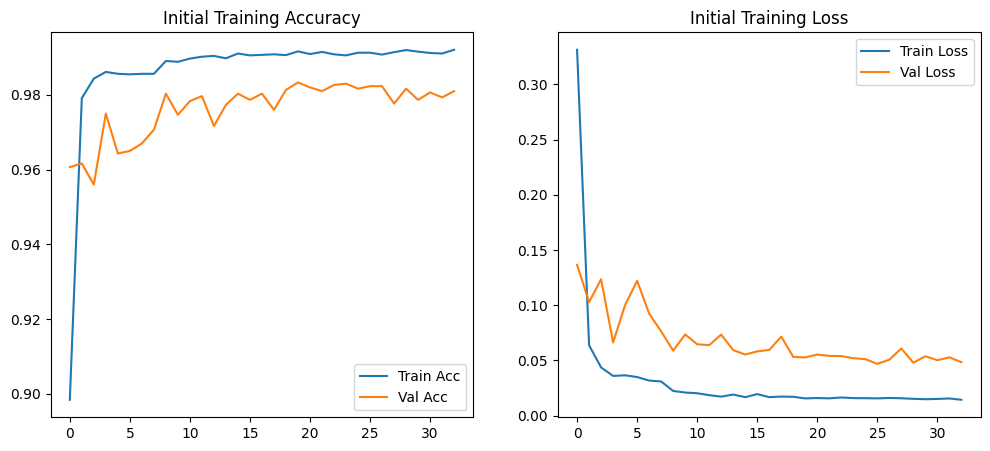

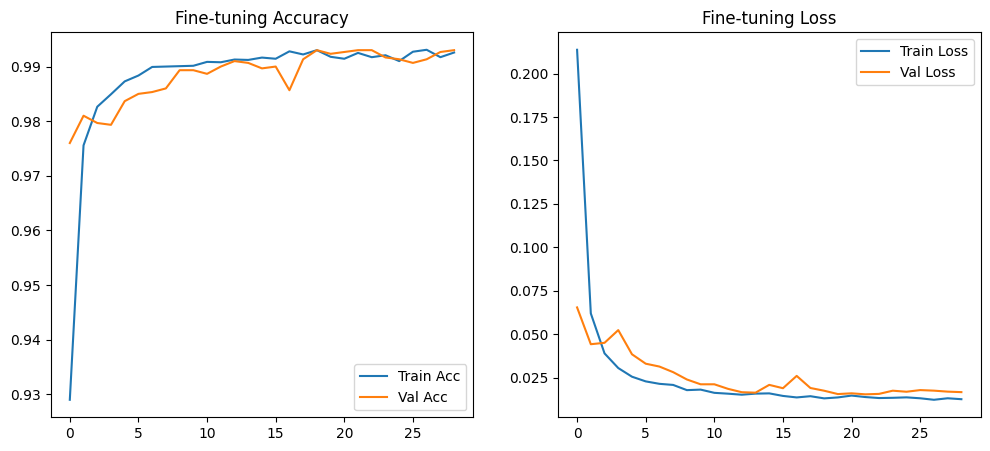

In [ ]:
def plot_history(history, title="Training"):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label="Train Acc")
    plt.plot(history.history['val_accuracy'], label="Val Acc")
    plt.title(f"{title} Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.title(f"{title} Loss")
    plt.legend()
    plt.show()

plot_history(history_1, "Initial Training")
plot_history(history_finetune, "Fine-tuning")

##*Confusion Matrix*

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step


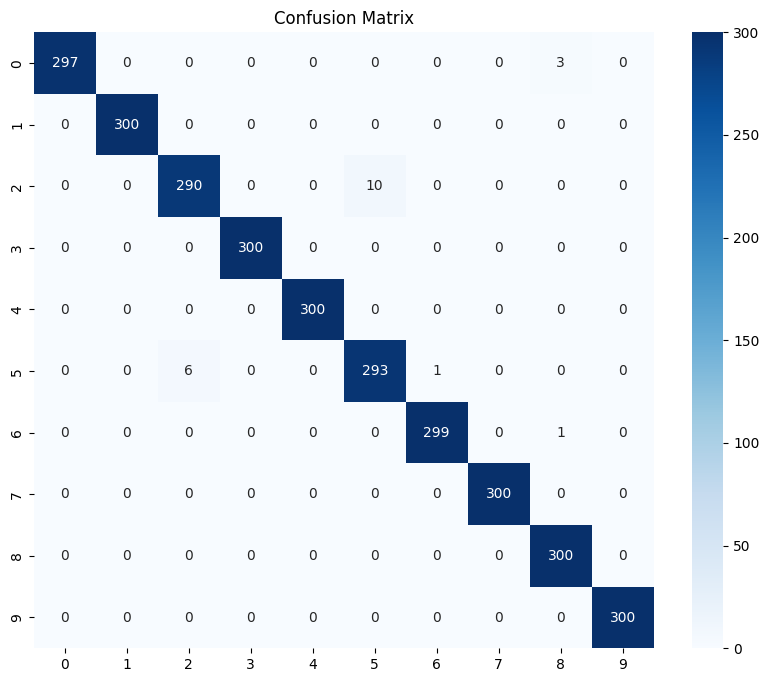

In [ ]:
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

##*Classification Report (Precision, Recall, F1)*

In [ ]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       300
           1       1.00      1.00      1.00       300
           2       0.98      0.97      0.97       300
           3       1.00      1.00      1.00       300
           4       1.00      1.00      1.00       300
           5       0.97      0.98      0.97       300
           6       1.00      1.00      1.00       300
           7       1.00      1.00      1.00       300
           8       0.99      1.00      0.99       300
           9       1.00      1.00      1.00       300

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



##*ROC Curve & AUC*

Overall AUC: 0.9999540740740741


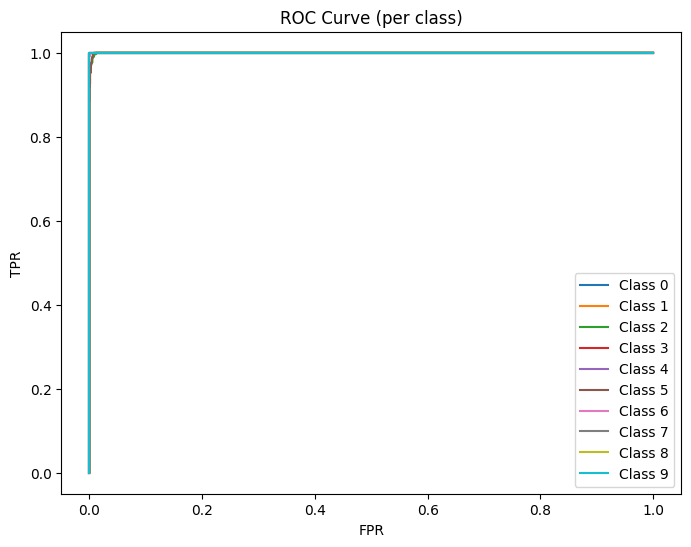

In [ ]:
num_classes = train_gen.num_classes
y_true_oh = tf.keras.utils.to_categorical(y_true, num_classes)
auc = roc_auc_score(y_true_oh, y_pred, multi_class='ovr')
print("Overall AUC:", auc)

plt.figure(figsize=(8,6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_oh[:,i], y_pred[:,i])
    plt.plot(fpr, tpr, label=f"Class {i}")
plt.title("ROC Curve (per class)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

##*Save Model*

In [ ]:
model.save("MobileNetV2_LeapGestRecog_Enhanced.keras")
print("Model saved successfully!")

Model saved successfully!
